# FRB Pipeline Detection

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib.pyplot import *
import gc
from scipy import signal
import math


In [2]:

def axis_labels(x, y, z):
    '''
    Creates the labels for the x, y axes and title as well as triggers the legend
    
    Note: Inputs must be strings
    
    
    INPUTS:
    
    x: (string) The label for the x-axis
    y: (string) The y-axis label
    z: (string) The title for the plot
    
    
    OUTPUTS:
    
    xlab   : The x-axis label
    ylab   : The y-axis label
    titles : The title
    legends: The legend of the plot
    
    '''
    
    xlab = xlabel(x)
    ylab = ylabel(y)
    titles = title(z)
    legends = legend
    return xlab, ylab, titles, legends


def peakfinder_pulsar_DM(x, threshold):
    '''
    Finds the peaks in a dedispersed pulsar that has been run through a matched filter with a Gaussian.
    
    Note: The array or list used for x must have two dimensions. The first specifying which DM we are looking at, and 
          the second representing the number of data points.
          
          The threshold must be appropriate for every DM. This means that it should have the same length as the 
          number of DMs
    
    
    INPUTS:
    
    x         : (array or list) The power of the pulse for every DM that has been looked at.
    threshold : (float) The y value at which peaks can be designated as peaks.
    
    
    OUTPUTS:
    
    peaksy: (list) The values ,for every DM, that can be called peaks over the threshold. 
    
    
    '''
    
    peaksx = [] #This is the values that the peaks are centred around
    peaksy = []
    for j in range(np.shape(x)[0]):
        peakssy= []
        DM_intensity = x[j]
        for i in range(len(DM_intensity)-2):
            if DM_intensity[i] > threshold[j] and DM_intensity[i-2]<DM_intensity[i] and DM_intensity[i-1] <DM_intensity[i] and DM_intensity[i+1] < DM_intensity[i] and DM_intensity[i+2] < DM_intensity[i]:
                peakssy.append(DM_intensity[i])
        peaksy.append(peakssy)
    return peaksy



#NOTE THAT THESE FORMULAS WERE TAKEN FROM GITHUB< I DO NOT CLAIM ANY OWNERSHIP TO THEM
def jd_to_date(jd):
    """
    Convert Julian Day to date.
    
    Algorithm from 'Practical Astronomy with your Calculator or Spreadsheet', 
        4th ed., Duffet-Smith and Zwart, 2011.
    
    Parameters
    ----------
    jd : float
        Julian Day
        
    Returns
    -------
    year : int
        Year as integer. Years preceding 1 A.D. should be 0 or negative.
        The year before 1 A.D. is 0, 10 B.C. is year -9.
        
    month : int
        Month as integer, Jan = 1, Feb. = 2, etc.
    
    day : float
        Day, may contain fractional part.
        
    Examples
    --------
    Convert Julian Day 2446113.75 to year, month, and day.
    
    >>> jd_to_date(2446113.75)
    (1985, 2, 17.25)
    
    """
    jd = jd + 0.5
    
    F, I = math.modf(jd)
    I = int(I)
    
    A = math.trunc((I - 1867216.25)/36524.25)
    
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I
        
    C = B + 1524
    
    D = math.trunc((C - 122.1) / 365.25)
    
    E = math.trunc(365.25 * D)
    
    G = math.trunc((C - E) / 30.6001)
    
    day = C - E + F - math.trunc(30.6001 * G)
    
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
        
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return year, month, day


def jy_to_datetime(jd):
    year, month, day = jd_to_date(jd)
    
    frac_days,day = math.modf(day)
    day = int(day)
    
    hour,min,sec,micro = days_to_hmsm(frac_days)
    
    #return (year,month,day,frac_days)
    return (hour,min,sec,micro)

def days_to_hmsm(days):
    """
    Convert fractional days to hours, minutes, seconds, and microseconds.
    Precision beyond microseconds is rounded to the nearest microsecond.
    
    Parameters
    ----------
    days : float
        A fractional number of days. Must be less than 1.
        
    Returns
    -------
    hour : int
        Hour number.
    
    min : int
        Minute number.
    
    sec : int
        Second number.
    
    micro : int
        Microsecond number.
        
    Raises
    ------
    ValueError
        If `days` is >= 1.
        
    Examples
    --------
    >>> days_to_hmsm(0.1)
    (2, 24, 0, 0)
    
    """
    hours = days * 24.
    hours, hour = math.modf(hours)
    
    mins = hours * 60.
    mins, min = math.modf(mins)
    
    secs = mins * 60.
    secs, sec = math.modf(secs)
    
    micro = round(secs * 1.e6)
    
    return int(hour), int(min), int(sec), int(micro)

In [3]:
309.92970599999984/147786

0.0020971520035727325

Pull the data from file into a variable to use

In [4]:
59*60+930771/1e6-53*60-51-1065/1e6

309.92970599999984

In [5]:
filename = "/home/andy/gr-transient_data_folder/data/J0332+5434_003_chB.sdf"
dt = np.float32
file = (np.fromfile(filename, dt, -1 ))

Load the file and reshape it into a matrix with dimentions number of spectra by number of time samples.

In [6]:
step = 513                                     # The number of spectra
nobs = int(file.size/step)            # Number of time samples
data= np.ndarray.flatten(file.astype("float")) # Turn the data into an array
data = (data.reshape(nobs, step))              # The reshaped file

In order to get the most accurate analysis possible, the timestep is calculated. This timestep is the same for all files with the same sampling rate and frequency range

In [7]:
step=513
data.shape

(147786, 513)

In [8]:
time1 = (jy_to_datetime(58670.495729179))
time2 = (jy_to_datetime(58670.499316328365))

total_time = (time2[1]*60+time2[2]+time2[3]/1e6-(time1[1]*60+time1[2]+time1[3]/1e6))
timestep = total_time/data.shape[0]

In [9]:
timestep

0.002097152003572733

In [10]:
frequency_axis = 500/(513*2)*np.arange(513)+(1400-500/4)

Look at the frequencies and decide which are suitable for being used. Those frequencies without significant rfi are desired.

In [11]:
figure()
plot(np.flip(frequency_axis, axis=0),10*np.log10(np.average(data, axis=0)))
axis_labels("Frequency (MHz)", "Power", "Total summed frequency across time of PSR B0329+54")
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/total_summed_frequency_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

The x_axes (in frequency) for the plots before the frequencies are summed is calculated, and additionally, the data is oriented such that time is on the x axis.

In [12]:
n_frequencies = np.fft.fftfreq(513, 
                               1/(250e6/1e6)       # This is the number of frequency channles.The first parameter
                              )                    # is the number of chanels desired, and the second is the 
                                                   # sample rate in MHz.

pulse_freqs = np.fft.fftshift(n_frequencies)+1400  # This will place the centre frequency of the plot at 1400MHz

dispersed = np.flip(np.transpose
                    ((data)), 0                    # The array of the data must be flipped to match the units in the
                   )                               # plot, and it must be transposed so that time is on the x axis.

The new orientation of the dta is plotted below

In [13]:
#This is the graph of the pulsar, where we can see that it is dispersed
figure()
imshow(abs(dispersed),aspect='auto',extent=[0,\
                            total_time,np.amax(frequency_axis),\
                            np.amin(frequency_axis),
                            ], vmax=30)
axis_labels('Time(s)','Frequency (MHz)',  'Dispersed Pulsar over Time')
colorbar(label = 'power')
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/freq_vs_time_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

To calculate the time delay needed to dedisperse, the cannoncial time delay equation is used to give the delay in seconds

In [14]:
DMs = np.linspace(0,200,201)             # Potential DMs are given here. For unknown pulsars, a range of DMs are 
                                         # guessed.


time_change = np.zeros((len(DMs), step)) # This is the time delay between the arrival of consecutive frequencies.
for i in range(len(DMs)):
    change = 4.148808e3*DMs[i]*\
            ( 1/(np.min(pulse_freqs))**2 
             - 1/( pulse_freqs )**2)     # Given by the definition of a time delay of a pulsar.
    
    time_change[i,:] = change[:]/(timestep)


The dediseprsion function is defined using np.roll. This functions exactly the same way that a line by line dedispersion would. Additionally, to save memory, the frequencies are summed in preparation to take the fft to get the power spectrum.

In [15]:
def dedispersion(DMss, frequency_channels, dispersed_pulse, time_change, lower_freq, high_freq): 
    """The function takes a set of DMs and dedisperses the given dispersed pulse for all the DMs given."""
    DM_measure = np.zeros((len(DMss),dispersed_pulse.shape[1])) # The dedispersed pulse will have the same shape as
                                                                # the dispersed one
    
                                                                
                                                           
    for i in range(len(DMss)):                                  # Dedispersion is calculated for every DM
        dedispers = np.zeros((dispersed_pulse.shape[0],\
                          dispersed_pulse.shape[1])
                        )   
        for j in range(frequency_channels):
            dedispers[j,:] = np.roll(dispersed_pulse[j,:],\
                            int(round(time_change[i,j]) )     # np.roll shifts the data over after the last
                                )                              # position and reintroduces it to the first position
        
        DM_measure[i,:] = np.sum(dedispers                     # The dedispersed pulsar is summed to take the power
                                 [lower_freq:high_freq],axis=0 # spectrum
                                )
    return DM_measure

Below the data is dedispersed. The first parameter is the DMs looked at. The second is the number of frequencies, the third is the dispersed data, the fourth is the time delay for each frequency, fifth is the minimum frequency that we want to look at, and sixth is the maximum frequency that will be looked at. 

In [16]:
DM_measure = dedispersion(DMs, step, dispersed, time_change,33,477)  #The data is dedispersed


The new dedispersed pulsar is plotted below.

In [17]:
figure()
imshow(abs(DM_measure),
                              aspect='auto',extent=[0,\
                            total_time,\
                            np.amax(DMs),np.amin(DMs)
                            ])
axis_labels('time(s)','DM',  'Summed Frequency for individual DM')
colorbar(label = 'power')                #This shows the effect the dedispersion had on the 200th DM

savefig("/home/andy/gr-radio_astro/docs/transient_documentation/dedispersed_summed_freq_perDM_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

The power spectrum of the data is taken below.

In [18]:
ffty = np.fft.fft(DM_measure, axis=1)

The power spectrum of the data is plotted below

In [19]:
figure()
imshow(abs(ffty[:,1:]),
                              aspect='auto',extent=[0,\
                            1/timestep,\
                            np.amax(DMs),np.amin(DMs)
                            ], vmax=10000)
axis_labels('Frequency(Hz)','DM',  'Power Spectrum of Dedispersed Pulsar')
colorbar(label = 'Power') 
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/Power_Spectrum_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

The new x axis in frequency is defined

In [20]:
f_step_size = 1/timestep/ffty.shape[1]

One DM of the power spectrum is plotted below, and is is clear that there is a pulse in it. The fist point of the power spectrum is not plotted because it is indicative of the system temperature, and it is enormous

In [21]:
figure()
plot(f_step_size*np.arange(ffty.shape[1]-1),abs(ffty[20,1:]))
axis_labels("Frequency(Hz)","Power","Power Spectrum for One DM")

savefig("/home/andy/gr-radio_astro/docs/transient_documentation/Power_Spectrum_DM=20_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

The data is run through a tukey window, to get rid of the ringing at the begining of the power sepctrum

In [22]:
window=(signal.tukey(ffty.shape[1], .006))  # The alpha parameter was found based on 
                                            # trial and error.

B=abs(window*ffty[:])                      # The data is run through a window

The new windowed data is plotted below

In [23]:
figure()
plot(f_step_size*np.arange(ffty.shape[1]),abs(B[28,:]), marker='.')
axis_labels("Frequency(Hz)","Power","Windowed Power Spectrum")
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/windowed_power_spectrum_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

In the current case, there is no noise file that can be drawn upon, so the noise is artificially created

The new windowed data is compared at different frequencies

In [24]:
figure()
plot(f_step_size*np.arange(147786),(B[28]), marker='.', label="DM=28")
plot(f_step_size*np.arange(147786),(B[0]), marker='.',label="DM=0")
xlim(0,100)
axis_labels("Frequency(Hz)","Power","Compared Windowed Power Spectrums")
legend()

savefig("/home/andy/gr-radio_astro/docs/transient_documentation/compared_windowed_power_spectrum_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

From this point there are two ways to analyze the data. If the obeserved object has a known period, then immediately below is the pipeline to detect it.

With the period of a signal known, it can be folded along its period to yeild a accurate signal to background noise. The number of integrations is decided by looking at the windowed data above. Usually around ten integrations of the period is recomended. This means that the frequency period is averaged over ten times the frequency period

In [25]:
period = 1/.714519
iterations = 10
start_position =5                                   #Determines which multiple of the period to start on

frequency_max = period*iterations
bin_shift =(round((period*abs(start_position))/f_step_size)) #Determines the total number of bins shifted from zero

max_bin = (round(period*(iterations+start_position)/f_step_size))


start_bin = (round((period*abs(start_position+1))/f_step_size))-(round((period*abs(start_position))/f_step_size))

# Determines the starting bin size in order to create the arrays
print("The max bin is", max_bin)
print("The bin shift is",bin_shift)
print("The start bin size is",start_bin)

iterations_new = iterations+1               # The modified iteration count for the "for loop"
new_pulse = np.zeros((np.shape(B)[0],start_bin))


# The position from the start of the data to begin folding from


for j in range(len(DM_measure)):
        
    if max_bin > np.shape(B)[1]:
        print(
            "Error: max bin larger than max size of data array"
        )
        break

    if bin_shift> np.shape(B)[1]:
        print(
            "Error: bin_shift larger than maximum size of data array"
        )
        break

    all_pulse = np.zeros(start_bin)
    count_phase = np.zeros(start_bin)
    pulse_dats= B[j, 1+bin_shift:max_bin+1]               # Sets the data to be looked at 
    
    con=np.zeros(0)                             # The counter for if the bin size changes
    old_bins=0                                  # The previous iteration bin size
    last_start = 0  # The last starting place in the frequency
    skip=0
    for i in range(1,iterations_new):
        bins = (round(period*(i+start_position)/f_step_size))\
             -(round(period*(i-1+start_position)/f_step_size)) # Determines the number of bins in one "period"
        
        print(last_start)
        #print(i)
        if bins == old_bins or old_bins == 0:
            #print(i) 
            all_pulse += np.concatenate(
                    
                (con,pulse_dats[last_start+skip:last_start+bins]) # If current and previous bin sizes are the same,
                                                             # con does not change
            )
            
            last_start += bins                               # Last start is updated
            #print(i)
            #print(last_start)
            
        elif int(old_bins)-int(bins) > 0:
            if skip-(int(old_bins)-int(bins))>=0:
                skip = skip-(int(old_bins)-int(bins))
                
                all_pulse +=np.concatenate(
                    
                    (con, pulse_dats[last_start+skip:last_start+bins]) # Current and previous bin sizes are not the same, so
                )                                                 # con is changed. Data is also determined
            
                
                
            else:
                print( old_bins)
                print(bins)
                con = np.zeros(
                    
                    len(con) + (abs(skip - (int(old_bins)-int(bins))))       # con is updated
                
                )
                skip=0
                
            
                all_pulse +=np.concatenate(
                    
                    (con, pulse_dats[last_start:last_start+bins]) # Current and previous bin sizes are not the same, so
                )                                                 # con is changed. Data is also determined
            
                last_start += bins                                # Last start is updated
                #print(i)
                #print(last_start)
        else:
            #print("two")
            if (len(con) - (int(bins)-int(old_bins)))>= 0:
                con = np.zeros(
                    len(con) - abs(int(bins)-int(old_bins))      # Con is updated
                )
                
                all_pulse +=np.concatenate(
                    
                    (con,pulse_dats[last_start:last_start+bins]) # Current and previous bin sizes are not the same.
                                                                 # Bin size has increased but is lower or equal to
                )                                                # the original bin size
                
                last_start += bins
            else:
                skip = abs(len(con) - (int(bins)-int(old_bins)))
                #print("three")
                all_pulse += pulse_dats[
                    last_start+skip    # Current and previous bin sizes are not the same.
                    :last_start+bins]                            # Bin size has increased but is greater than the 
                                                                 # original bin size.
                
                last_start +=bins                                # Last start is updated
                
                con = np.zeros(0)                                # Con is reset to 0
            #print(i)
            #print(last_start)
        
        #print(last_start)
        old_bins = bins                                          # old bins is updated
    new_pulse[j,:] = np.fft.fftshift(all_pulse/iterations) # The folded pulse is determined for each freq

The max bin is 6506
The bin shift is 2169
The start bin size is 434
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
43

867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
3036
3470
3904
434
433
0
434
434
433
867
1301
1735
2169
434
433
2602
30

The new folded pulse is is plotted below

In [26]:
figure()
plot(1/start_bin*np.arange(start_bin),(new_pulse[28]), marker='.')
axis_labels("Phase"," Averaged Power","Averaged Power over 10 Iterations")
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/averaged_power_over10_iterations_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

A rough signal to noise ratio is calculated below for a specified frequency

In [27]:
np.max(new_pulse[28])/np.mean(new_pulse[28])

17.287201059778415

Currently there is no "noise" data set, so an artificial noise set is created. This is not as accurate as actual noise, and is open to interpretation for what is the best way to do it. Below the data points above a theshold are considered signal, and so are turned into the mean of the noise. The problem with turning signal into noise is that the fft of the signal will have a higher std than not, near the correct DM, skewing where the highest DM is, since the std across all frequencies should be roughly the same.

In [28]:
new_pulse_noise = new_pulse*0
for j in range(new_pulse.shape[0]):
    for i in range(new_pulse.shape[1]):
        if new_pulse[j,i] > np.mean(new_pulse[j,:])+np.std(new_pulse[j,:]): # The threshold is 3 std above the average
            
            new_pulse_noise[j,i] = np.mean(new_pulse[j,:])                    # Points above the threshold are given
                                                                              # a value of the mean of the data
        else:
            new_pulse_noise[j,i] = new_pulse[j,i]

In [29]:
np.mean(new_pulse[j,:])+np.std(new_pulse[j,:])*3

4415.090139569553

Typically a peak finding function would be implemented and the peaks of the data set would be found. However by our algorithm, there will only be one peak that matters and that should be the maximum. This peak is already the average of the frequency peaks in the power spectrum. Therefore only the maximum value of the data is taken as the "maximum" for the signal to noise ratio. The mean and std of the "noise" is taken to yeild the SNR. The SNR is given by \begin{equation} \frac{\langle y \rangle}{\sigma_y} \end{equation}.

In [30]:
maximums_p = np.zeros(len(new_pulse))
for i in range(len(new_pulse)):
    maximums_p[i] = np.max(new_pulse[i])
    
#Find the mean and standard deviation
corr_mean_p = np.mean(new_pulse_noise, axis=1)
corr_std_p = np.std(new_pulse_noise, axis=1)

SNR_p = (maximums_p-corr_mean_p)/(corr_std_p)

The SNR is plotted below

In [31]:
figure()
plot(np.arange(len(DMs)),SNR_p)
axis_labels("DM"," SNR","SNR per DM of PSR B0329+54")

savefig("/home/andy/gr-radio_astro/docs/transient_documentation/SNR_iterated_PSR_B0329+54_Prince_scope.png")

<IPython.core.display.Javascript object>

When the period of the obkect is not known, a more rough calculation of its signal to noise can be done, to check that an object has actually been discovered. Additionally, for now, no noise of the data has been collected, so it will be artificially made, with roughly the same accuracy as above

In [32]:
B_noise = B*0
for j in range(B.shape[0]):
    for i in range(B.shape[1]):
        if B[j,i] > 8000:
            B_noise[j,i] = np.mean(B[j,:])
        else:
            B_noise[j,i] = B[j,i]
            
        

The new noise is plotted down below

<IPython.core.display.Javascript object>


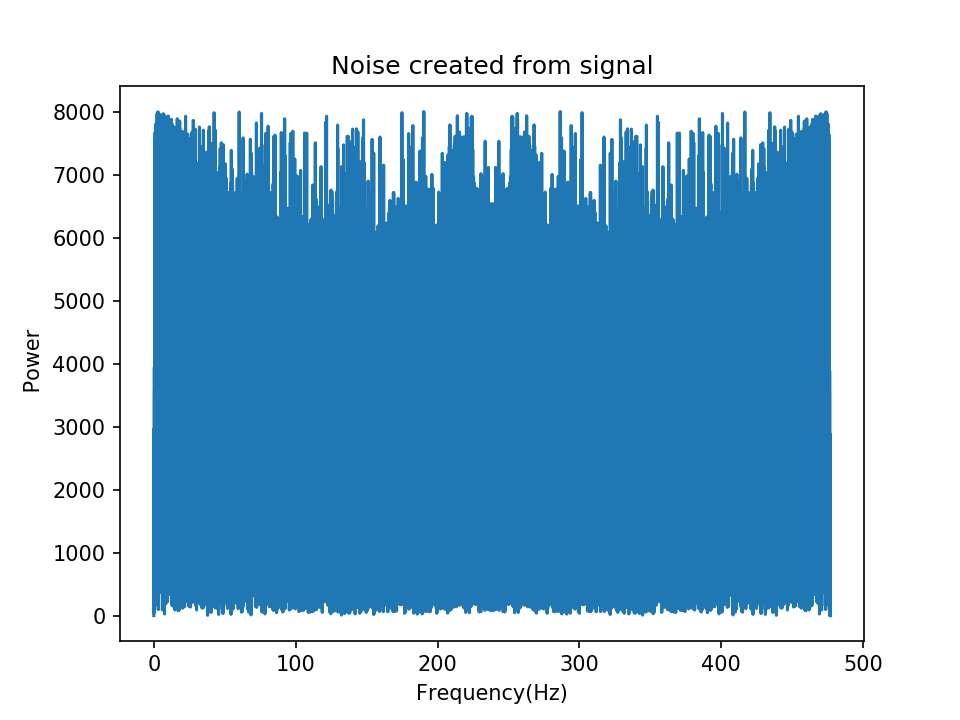

In [39]:
figure()
plot(f_step_size*np.arange(147786),B_noise[28])
axis_labels("Frequency(Hz)"," Power","Noise created from signal")
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/hacked_noise_PSR_B0329+54_Prince_scope.png")

To detect whether or not a pulsar or FRB was detected, a matched filter will be implemented. Since we are dealing with an ideal case of white noise, then the filter that will be applied will be a pulse of the same width as the signal. This width is calculated by taking the original sigma of simulated pulse and dividing it by the final timestep after all modification of the pulse is done. This occurrs after integration. Then the gaussian pulse that will be used as the filter is created. The length is made such that packets are not significantly overlapping.

In [34]:
#Now we will begin to try to impliment the matched filter
#Define the standard deviation of the noise

#Define the pulse shape by the standard deviation of one pulse
#packet_length = int(len(downsampled_filtered_mixed_down_s)/step/(integration_size))
#standards = pw/(period/packet_length)

gau = np.exp(.5*-( np.arange(-int(25/2),int(25/2)) /.9)**2)

The cross correlation between the data and the filter is the implemented below. The correlation for signal and filter is specified to give the same shaped array as the data given to it. The noise is also run through the matched filter, but the correlation is specified to give onyl real values. This ensures that the standard deviation will not be increased by a factor of ten from if just the real valued correlations were taken. 

In [35]:
#Now perform the cross correlation between the signal and the simulated
#B_noise = B[np.where]
correlates = []
corr_bb = []
for i in range(len(DM_measure)):
    correlates.append(signal.correlate(B[i], gau, mode='same'))
    corr_bb.append(signal.correlate(B_noise[i],gau,mode='valid'))
correlates = np.asarray(correlates)
corr_bb = np.asarray(corr_bb)


The pulsar will be considered detected if the signal to noise ratio, given by
\begin{equation} \frac{\langle y \rangle}{\sigma_y} \end{equation}
is over a threshold. The average value of y is the average value of the correlated signal. This is found by using a peak finding function for each DM and then take the average of those peaks.

In [36]:
#We can find the peaks

mean_heights = np.zeros(len(correlates))
for i in range(len(correlates)):
    mean_heights[i] = np.mean(correlates[i])
peak_heights = peakfinder_pulsar_DM(correlates, mean_heights*20)
for i in range(len(correlates)):
    count=2
    while len(peak_heights[i])< 12:
        peak_heights[i:] = (peakfinder_pulsar_DM(correlates[:], mean_heights[:]*20/count))[i:]
        count += 1
        if count==10:
            break

Now the vaience of the non pulse signal is found. This is done by pointing the telescope somewhere else and observing the noise for a brief period. The data collected is assumed to not have a pulsar in it. This data, which by this point has been run through the matched filter, is used to now find the mean and standard deviation along the time axis.

In [37]:
maximums = np.zeros(len(peak_heights))
for i in range(len(peak_heights)):
    maximums[i] = np.mean(peak_heights[i])
    
#Find the mean and standard deviation
corr_mean = np.mean(corr_bb, axis=1)
corr_std = np.std(corr_bb, axis=1)

SNR = (maximums-corr_mean)/(corr_std.mean())

The std of the cross correlated noise and the noise itself are plotted below

<IPython.core.display.Javascript object>


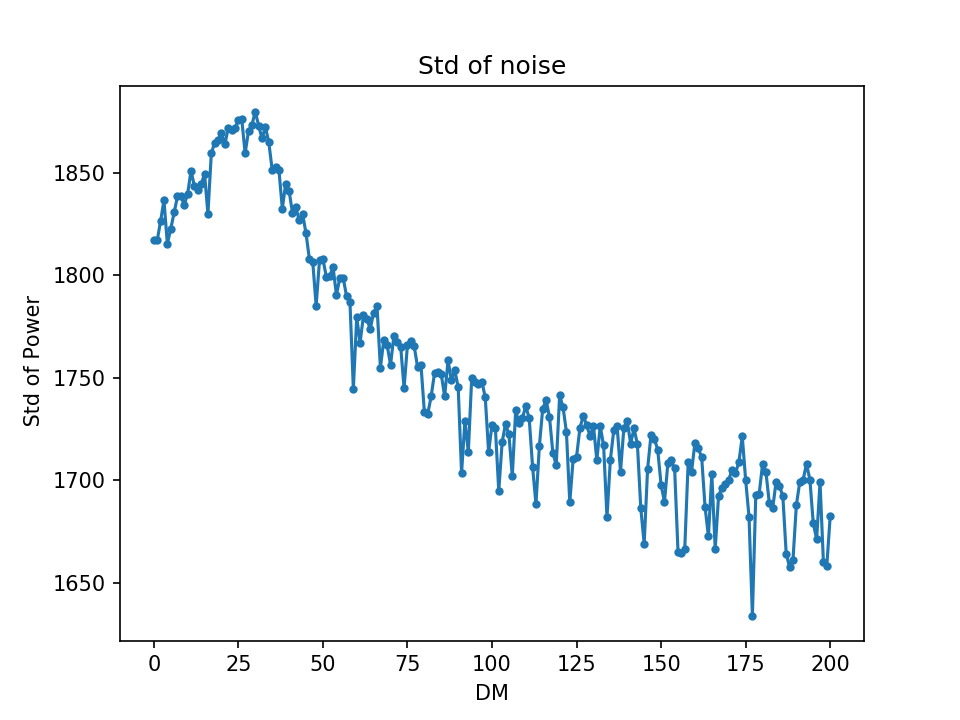

<IPython.core.display.Javascript object>


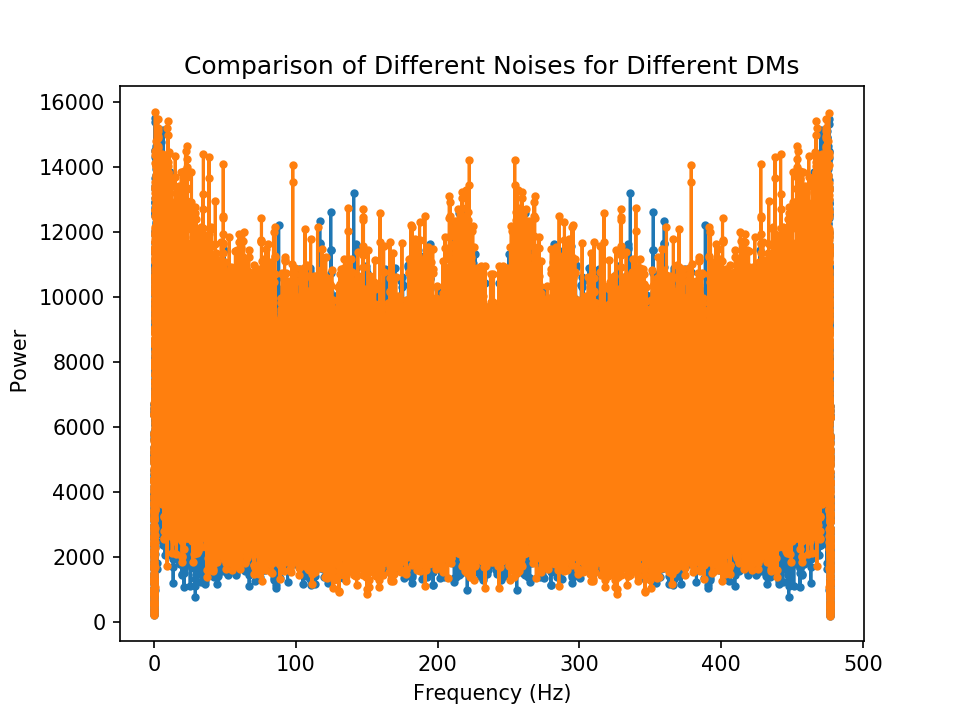

In [46]:
figure()
plot(np.arange(len(DMs)),corr_std, marker='.')
axis_labels("DM"," Std of Power","Std of noise")
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/std_noperiod_noise_PSR_B0329+54_Prince_scope.png")

figure()
plot(f_step_size*np.arange(corr_bb[199].shape[0]),corr_bb[199], marker='.')
plot(f_step_size*np.arange(corr_bb[28].shape[0]),corr_bb[28], marker='.')
axis_labels("Frequency (Hz)"," Power","Comparison of Different Noises for Different DMs")
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/compared_noperiod_noise_PSR_B0329+54_Prince_scope.png")

The plot of SNR to DM is plotted

In [ ]:
figure()
#plot(maximums-corr_mean)
plot(np.arange(len(DMs)),SNR)
axis_labels('DM', 'Signal to Noise Ratio', 'Approximate SNR per DM of PSR B0329+54')
savefig("/home/andy/gr-radio_astro/docs/transient_documentation/SNR_noperiod_PSR_B0329+54_Prince_scope.png")